In [1]:
import numpy as np
import copy
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Define Theory

In [ ]:
def get_action(phi, k, l):
    return np.sum(-2 * k * phi * (np.roll(phi, 1, 0) + np.roll(phi, 1, 1))
                  + (1 - 2 * l) * phi**2 
                  + l * phi**4)

def get_drift(phi, k, l):
    return (2 * k * (np.roll(phi, 1, -1) + np.roll(phi, -1, -1)
                     + np.roll(phi, 1, -2) + np.roll(phi, -1, -2))
            + 2 * phi * (2 * l * (1 - phi**2) - 1))

def get_hamiltonian(chi, action):
    return 0.5 * np.sum(chi**2) + action

# Sampling Scheme

In [3]:
def hmc(phi_0, S_0, k, l, n_steps=100):
    dt = 1 / n_steps

    phi = phi_0
    chi = np.random.randn(*phi.shape)
    H_0 = get_hamiltonian(chi, S_0)

    chi += 0.5 * dt * get_drift(phi, k, l)
    for i in range(n_steps-1):
        phi += dt * chi
        chi += dt * get_drift(phi, k, l)
    phi += dt * chi
    chi += 0.5 * dt * get_drift(phi, k, l)

    S = get_action(phi, k, l)
    dH = get_hamiltonian(chi, S) - H_0

    if dH > 0:
        if np.random.rand() >= np.exp(-dH):
            return phi_0, S_0, False
    return phi, S, True

In [4]:
L = 32
k = 0.3
l = 0.02

phi = np.random.randn(L,L)
S = get_action(phi, k, l)

In [5]:
for _ in tqdm(range(1000)):
    phi, S, accepted = hmc(phi, S, k, l)

100%|██████████| 1000/1000 [00:09<00:00, 105.37it/s]


In [6]:
cfgs = []

for i in tqdm(range(10000)):
    phi, S, accepted = hmc(phi, S, k, l)
    
    if i % 10 == 0:
        cfgs.append(copy.deepcopy(phi))
        
cfgs = np.array(cfgs)

100%|██████████| 10000/10000 [01:31<00:00, 109.87it/s]


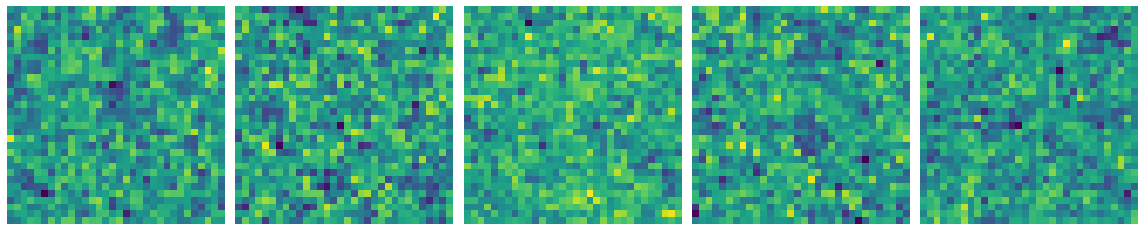

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))  # Switched figsize to match 1 row, 5 columns
i=  10
for i, id in enumerate([1,2,3,4,5]):
    axes[i].imshow(cfgs[id], cmap='viridis')  # You can change cmap as needed
    axes[i].axis('off')  # Optional: remove axes for cleaner look
plt.tight_layout()
plt.show()

In [25]:
def jackknife(samples: np.ndarray):
    """Return mean and estimated lower error bound."""
    means = []

    for i in range(samples.shape[0]):
        means.append(np.delete(samples, i, axis=0).mean(axis=0))

    means = np.asarray(means)
    mean = means.mean(axis=0)
    error = np.sqrt((samples.shape[0] - 1) * np.mean(np.square(means - mean), axis=0))
    
    return mean, error

In [26]:
def get_mag(cfgs: np.ndarray):
    """Return mean and error of magnetization."""
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])
    return jackknife(cfgs.mean(axis=axis))

def get_abs_mag(cfgs: np.ndarray):
    """Return mean and error of absolute magnetization."""
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])
    return jackknife(np.abs(cfgs.mean(axis=axis)))

def get_chi2(cfgs: np.ndarray):
    """Return mean and error of suceptibility."""
    V = np.prod(cfgs.shape[1:])
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])
    mags = cfgs.mean(axis=axis)
    return jackknife(V * (mags**2 - mags.mean()**2))

def get_corr_func(cfgs: np.ndarray):
    """Return connected two-point correlation function with errors for symmetric lattices."""
    mag_sq = np.mean(cfgs)**2
    corr_func = []
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])

    for i in range(1, cfgs.shape[1], 1):
        corrs = []

        for mu in range(len(cfgs.shape)-1):
            corrs.append(np.mean(cfgs * np.roll(cfgs, i, mu+1), axis=axis))

        corrs = np.array(corrs).mean(axis=0)
        corr_mean, corr_err = jackknife(corrs - mag_sq)
        corr_func.append([i, corr_mean, corr_err])

    return np.array(corr_func)

In [29]:
M, M_err = get_mag(cfgs)
M_abs, M_abs_err = get_abs_mag(cfgs)
chi2, chi2_err = get_chi2(cfgs)

print("M = %.4f +/- %.4f" % (M, M_err))
print("|M| = %.4f +/- %.4f" % (M_abs, M_abs_err))
print("chi2 = %.4f +/- %.4f" % (chi2, chi2_err))

M = 2.1948 +/- 0.0012
|M| = 2.1948 +/- 0.0012
chi2 = 1.3635 +/- 5.1812


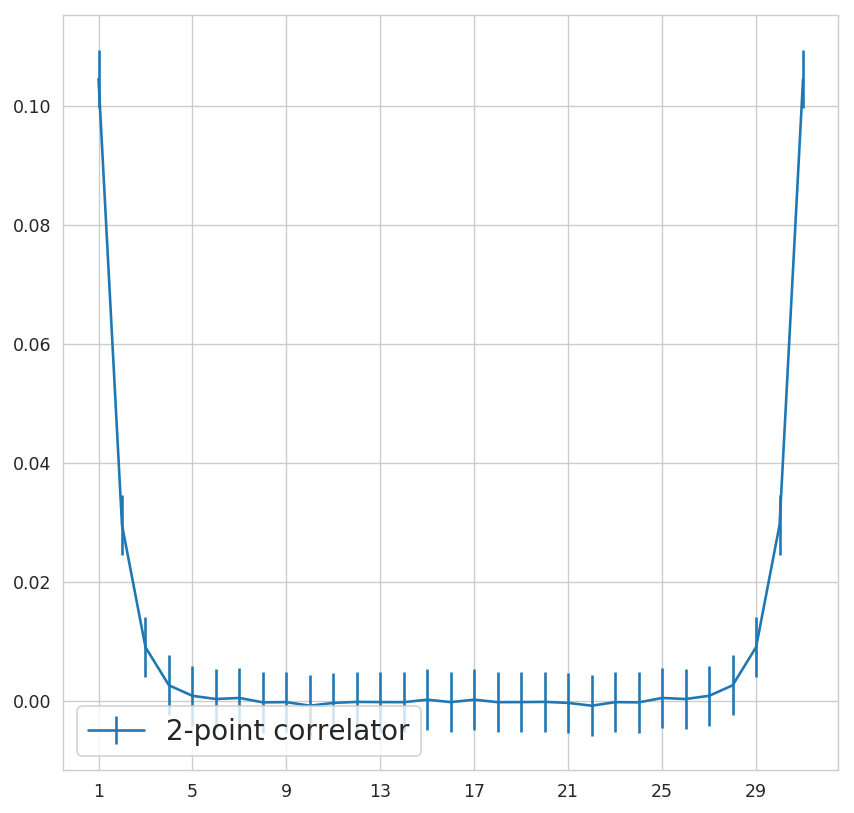

In [30]:
corr_func = get_corr_func(cfgs)

fig, ax = plt.subplots(1,1, dpi=125, figsize=(8,8))
plt.xticks([i for i in range(1, L, 4)])
ax.errorbar(corr_func[:,0], corr_func[:,1], yerr=corr_func[:,2], label='2-point correlator')
plt.legend(prop={'size': 16})
plt.show()